In [9]:
import pandas as pd
import janitor
from utilities import calculate_summary_statistics, pandas_to_tex, save_mpl_fig

import warnings

warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
import statsmodels.api as sm

sns.set_theme(context="notebook", font_scale=1.35, style="whitegrid", palette="dark")

df = pd.read_csv("../data/ind_data.csv")
df.head(3)

,caseid,duration,visits,duration_min,duration_hr,harmless,malicious,suspicious,undetected,timeout,...,educ,pid3,pid7,presvote20post,inputstate,region,gender_lab,race_lab,educ_lab,agegroup_lab
0,47541,263115,17194,4385,73,37198,19,5,11033,0,...,2,2,6,2,12,3,Female,White,HS or Below,65+
1,56565,187793,11479,3129,52,22541,10,3,6576,0,...,3,3,5,2,17,2,Female,White,Some college,65+
2,203271,94510,6540,1575,26,10298,8,2,2943,0,...,6,1,2,-1,54,3,Female,White,Postgrad,35-49


## Exposure by demo

### Tabulate

In [2]:
percentiles = [5, 10, 25, 50, 75, 90, 95]

In [3]:
gender_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="gender_lab",
    value_column="malicious_min",
    percentiles=percentiles,
)
pandas_to_tex(gender_mal_bool_summ, "../tabs/gender_mal_minutes_summ")
gender_mal_bool_summ

,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,Female,595 (52.5\%),15.8,150.8,0,0.0,0.0,0.0,0.0,1.0,8.6,31.3,2879
1,Male,539 (47.5\%),10.8,50.5,0,0.0,0.0,0.0,0.0,4.0,18.0,50.0,890


In [4]:
race_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="race_lab",
    value_column="malicious_min",
    percentiles=percentiles,
)
pandas_to_tex(race_mal_bool_summ, "../tabs/race_mal_minutes_summ")
race_mal_bool_summ

,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,White,720 (63.5\%),14.5,140.1,0,0.0,0.0,0.0,0.0,2.0,9.0,30.1,2879
1,Hispanic,168 (14.8\%),6.5,28.0,0,0.0,0.0,0.0,0.0,1.0,9.0,21.3,250
2,Black,144 (12.7\%),19.8,62.3,0,0.0,0.0,0.0,0.0,5.2,43.8,128.5,407
3,Other,56 (4.9\%),10.0,33.3,0,0.0,0.0,0.0,0.0,6.0,21.0,39.8,229
4,Asian,46 (4.1\%),5.8,15.5,0,0.0,0.0,0.0,0.0,1.0,17.0,49.8,64


In [5]:
educ_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="educ_lab",
    value_column="malicious_min",
    percentiles=percentiles,
)
pandas_to_tex(educ_mal_bool_summ, "../tabs/educ_mal_minutes_summ")
educ_mal_bool_summ

,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,HS or Below,411 (36.2\%),20.9,178.3,0,0.0,0.0,0.0,0.0,3.0,10.0,41.0,2879
1,Some college,326 (28.7\%),11.7,67.4,0,0.0,0.0,0.0,0.0,2.0,14.5,40.8,890
2,College,255 (22.5\%),9.2,35.3,0,0.0,0.0,0.0,0.0,2.0,11.0,51.8,321
3,Postgrad,142 (12.5\%),3.0,8.2,0,0.0,0.0,0.0,0.0,1.0,9.0,18.0,49


In [6]:
category_names = {
    "<25": "$<$ 25",
    "25-34": "25--34",
    "35-49": "35--49",
    "50-64": "50--64",
    "65+": "$>$ 65",
}
agegroup_mal_bool_summ = calculate_summary_statistics(
    df,
    groupby_column="agegroup_lab",
    value_column="malicious_min",
    percentiles=percentiles,
    sort_order="custom",
#     custom_order=["<25", "25--50", "50--65", "65+"],
    custom_order=category_names.keys(),
    category_names=category_names,
)
pandas_to_tex(agegroup_mal_bool_summ, "../tabs/agegroup_mal_minutes_summ")
agegroup_mal_bool_summ

,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max
0,$<$ 25,93 (8.2\%),13.6,44.6,0,0.0,0.0,0.0,0.0,5.0,31.8,63.2,329
1,25--34,200 (17.6\%),28.7,209.1,0,0.0,0.0,0.0,0.0,2.0,29.4,85.9,2879
2,35--49,285 (25.1\%),5.3,21.7,0,0.0,0.0,0.0,0.0,1.0,8.6,27.8,192
3,50--64,288 (25.4\%),17.0,135.3,0,0.0,0.0,0.0,0.0,2.0,13.0,34.6,2067
4,$>$ 65,268 (23.6\%),6.6,45.0,0,0.0,0.0,0.0,0.0,3.0,9.0,19.6,711


### eCDF

In [11]:
df['malicious_min'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99])

count    1134.000000
mean       13.395944
std       114.626879
min         0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         1.000000
80%         4.000000
90%        12.000000
95%        37.000000
96%        50.000000
97%        74.020000
98%       109.680000
99%       205.400000
max      2879.000000
Name: malicious_min, dtype: float64

In [18]:
line_styles = ["-", "--", "-.", ":"]  # Different line styles for distinct appearance
# colors = ["#0B1B32", "#83A6CE", "#0D1E4C", "#C48CB3", "#E5C9D7", "#26415E"]
colors = ["#88CCEE", "#CC6677", "#4477AA", "#DDCC77", "#117733", "#AA4499"]

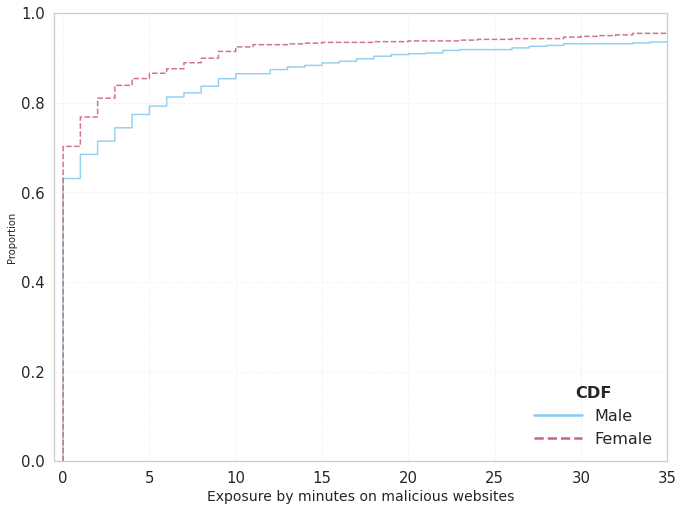

In [19]:
# Gender
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.ecdfplot(data=df, x="malicious_min", hue="gender_lab", alpha=0.9, ax=ax)

# =================================================
# Modify lines
unique_groups = df["gender_lab"].unique()[::-1]
for i, (line, group) in enumerate(zip(ax.get_lines(), unique_groups)):
    line.set_color(colors[i])
    line.set_linestyle(line_styles[i % len(line_styles)])
    line.set_linewidth(1.5)


# =================================================
# Legend
legend_handles = [
    Line2D(
        [0],
        [0],
        color=colors[i],
        lw=2.5,
        linestyle=line_styles[i % len(line_styles)],
        label=group,
    )
    for i, group in enumerate(unique_groups)
]

plt.legend(
    handles=legend_handles,  # Pass custom handles here
    title="CDF",
    loc="lower right",
    fontsize=16,
    title_fontproperties={"weight": "bold"},  # Bold title
    frameon=False,  # No border around the legend
    handlelength=3,  # Increase line length in legend
)

# =================================================
plt.xlabel("Exposure by minutes on malicious websites", fontsize=14)
ax.set_xlim(-0.5, 35)
# plt.xticks(np.arange(0, 9, 1))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/cdf-mal-minutes-gender")

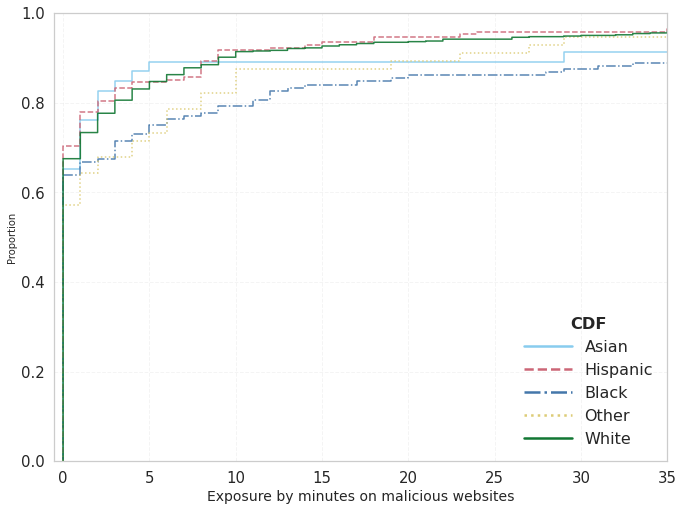

In [20]:
# Race
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.ecdfplot(data=df, x="malicious_min", hue="race_lab", alpha=0.9, ax=ax)

# =================================================
# Modify lines
unique_groups = df["race_lab"].unique()[::-1]
for i, (line, group) in enumerate(zip(ax.get_lines(), unique_groups)):
    line.set_color(colors[i])
    line.set_linestyle(line_styles[i % len(line_styles)])
    line.set_linewidth(1.5)


# =================================================
# Legend
legend_handles = [
    Line2D(
        [0],
        [0],
        color=colors[i],
        lw=2.5,
        linestyle=line_styles[i % len(line_styles)],
        label=group,
    )
    for i, group in enumerate(unique_groups)
]

plt.legend(
    handles=legend_handles,  # Pass custom handles here
    title="CDF",
    loc="lower right",
    fontsize=16,
    title_fontproperties={"weight": "bold"},  # Bold title
    frameon=False,  # No border around the legend
    handlelength=3,  # Increase line length in legend
)

# =================================================
plt.xlabel("Exposure by minutes on malicious websites", fontsize=14)
ax.set_xlim(-0.5, 35)
# plt.xticks(np.arange(0, 9, 1))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/cdf-mal-minutes-race")

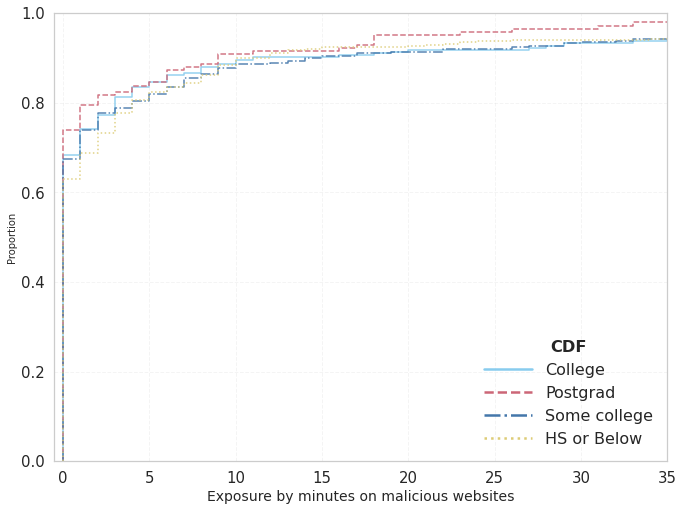

In [22]:
# Education
_scale = 0.8
_aspect_ratio = (12, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

sns.ecdfplot(data=df, x="malicious_min", hue="educ_lab", alpha=0.9, ax=ax)

# =================================================
# Modify lines
unique_groups = df["educ_lab"].unique()[::-1]
for i, (line, group) in enumerate(zip(ax.get_lines(), unique_groups)):
    line.set_color(colors[i])
    line.set_linestyle(line_styles[i % len(line_styles)])
    line.set_linewidth(1.5)


# =================================================
# Legend
legend_handles = [
    Line2D(
        [0],
        [0],
        color=colors[i],
        lw=2.5,
        linestyle=line_styles[i % len(line_styles)],
        label=group,
    )
    for i, group in enumerate(unique_groups)
]

plt.legend(
    handles=legend_handles,  # Pass custom handles here
    title="CDF",
    loc="lower right",
    fontsize=16,
    title_fontproperties={"weight": "bold"},  # Bold title
    frameon=False,  # No border around the legend
    handlelength=3,  # Increase line length in legend
)

# =================================================
plt.xlabel("Exposure by minutes on malicious websites", fontsize=14)
ax.set_xlim(-0.5, 35)
# plt.xticks(np.arange(0, 9, 1))
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/cdf-mal-minutes-education")

## Plot age

In [23]:
bins = [1930, 1958, 1973, 1988, 1998, 2003]
labels = ["65+", "50-64", "35-49", "25-34", "< 25"]

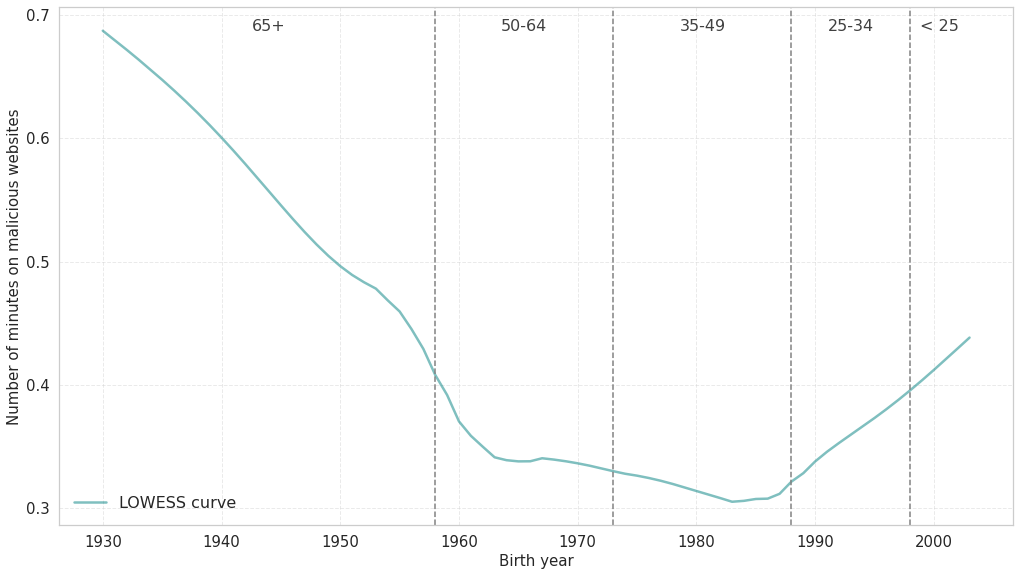

In [24]:
_scale = 0.9
_aspect_ratio = (16, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

lowess = sm.nonparametric.lowess(
    df["malicious_min"],
    df["birthyr"],
    frac=0.5,
)

plt.plot(
    lowess[:, 0], lowess[:, 1], color="teal", lw=2.5, alpha=0.5, label="LOWESS curve"
)

plt.legend(frameon=False, loc="lower left", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel("Birth year", size=15)
plt.ylabel("Number of minutes on malicious websites", size=15)
plt.tight_layout()
plt.locator_params(axis="y", nbins=8)
save_mpl_fig("../figs/lowess-mal-minutes-birthyr")

for i in range(len(bins) - 1):
    mid_point = (bins[i] + bins[i + 1]) / 2
    plt.text(
        mid_point,
        max(lowess[:, 1]) * 1,
        f"{labels[i]}",
        ha="center",
        fontsize=16,
        color=".25",
    )

# Add vertical lines for each inner boundary
for birth_year in bins[1:-1]:
    plt.axvline(x=birth_year, color="grey", linestyle="--", lw=1.5)

save_mpl_fig("../figs/lowess-mal-minutes-birthyr-annotated")

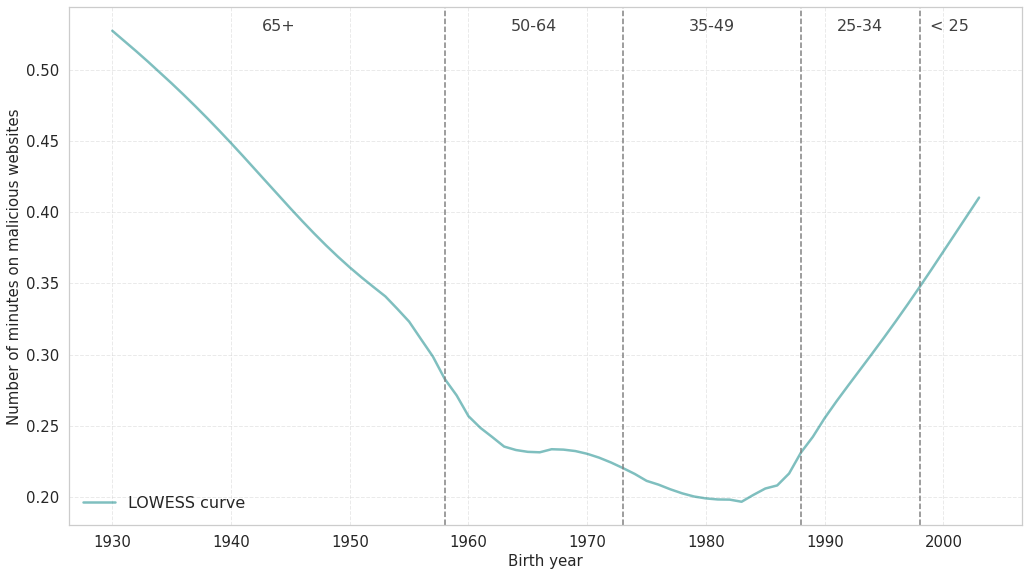

In [25]:
_scale = 0.9
_aspect_ratio = (16, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

winsorized_mal_mins = winsorize(df["malicious_min"], limits=(0.0, 0.2))

lowess = sm.nonparametric.lowess(winsorized_mal_mins, df["birthyr"], frac=0.5)

plt.plot(
    lowess[:, 0], lowess[:, 1], color="teal", lw=2.5, alpha=0.5, label="LOWESS curve"
)

plt.legend(frameon=False, loc="lower left", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel("Birth year", size=15)
plt.ylabel("Number of minutes on malicious websites", size=15)
plt.tight_layout()
plt.locator_params(axis="y", nbins=8)
save_mpl_fig("../figs/lowess-mal-minutes-birthyr-winsorized")


for i in range(len(bins) - 1):
    mid_point = (bins[i] + bins[i + 1]) / 2
    plt.text(
        mid_point,
        max(lowess[:, 1]) * 1,
        f"{labels[i]}",
        ha="center",
        fontsize=16,
        color=".25",
    )

# Add vertical lines for each inner boundary
for birth_year in bins[1:-1]:
    plt.axvline(x=birth_year, color="grey", linestyle="--", lw=1.5)

save_mpl_fig("../figs/lowess-mal-minutes-birthyr-winsorized-annotated")